# Jakub's FYP particle tracking script

In this script we will take a video input from our high speed camera and perform particle tracking on it to derive a normalised velocity field.

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage import morphology, util, filters, io, exposure, data
import numpy as np
import pandas as pd
import trackpy as tp
from pandas import DataFrame, Series  # for convenience
from IPython.display import display, HTML
import pims
import os
import cv2
import random
from datetime import datetime

# Define some utility functions that we will use later
def generate_filename(extension):
   time = datetime.now().strftime("%d-%m-%Y_%H-%M-%S")

   if (extension != ""):
      fname = f"Capture_{time}.{str(extension)}"
      return fname
    
   return f"Capture_{time}"

def is_variable_loaded(name):
    return name in globals()

def save_table_backup(table,name):
    table.to_pickle(os.path.join(WORKING_PATH,'Data',name))

def read_table_backup(name):
    return pd.read_pickle(os.path.join(WORKING_PATH,'Data',name))  
  

# change the following to %matplotlib notebook for interactive plotting
%matplotlib inline

# Optionally, tweak styles.
mpl.rc('figure',  figsize=(10, 5))
mpl.rc('image', cmap='gray')
display(HTML("<style>div.output_scroll { height: max-content; }</style>"))

In [2]:
FOLDER_NAME = "VideoCapture_10-03-2022_15-36-13 (Attempt 8 - 4g graphite - fresh, 200ml deionised, 0.5ml fairy)"
WORKING_PATH = 'C:\\Users\\jakub\\Desktop\\graphene\\tests\\Particle tracking'
OUTPUTS_PATH = os.path.join(WORKING_PATH, 'Output files')

IMAGES_PATH =  os.path.join(WORKING_PATH, 'Images', FOLDER_NAME, "*.jpg")
print(IMAGES_PATH)
FRAMES_PER_SECOND = 483.33
FRAME_TIME = 1 / FRAMES_PER_SECOND

C:\Users\jakub\Desktop\graphene\tests\Particle tracking\Images\VideoCapture_10-03-2022_15-36-13 (Attempt 8 - 4g graphite - fresh, 200ml deionised, 0.5ml fairy)\*.jpg


### Load the variables from memory if they have been precalculated earlier

This is handy if you want to carry on working on your dataset after restarting Jupyter Notebook. Those datasets can take a while to calculate, so I thought it would make a lot of sense to back them up to disk and attempt to read them if they're available before recalculating.

In [3]:
# Load variables is available to speed up workflow
if not (is_variable_loaded("f_0")):
    try:
        f = read_table_backup("f_0.pkl")
        print("Loaded f_0.pkl from memory")
    except:
        print("The file f_0.pkl does not exist")

if not (is_variable_loaded("f")):
    try:
        f = read_table_backup("f.pkl")
        print("Loaded f.pkl from memory")
    except:
        print("The file f.pkl does not exist")
        
if not (is_variable_loaded("t")):
    try:
        t = read_table_backup("t.pkl")
        print("Loaded t.pkl from memory")
    except:
        print("The file t.pkl does not exist")
        
if not (is_variable_loaded("t1")):
    try:
        t1 = read_table_backup("t1.pkl")
        print("Loaded t1.pkl from memory")
    except:
        print("The file t1.pkl does not exist")
        
if not (is_variable_loaded("t2")):
    try:
        t2 = read_table_backup("t2.pkl")
        print("Loaded t2.pkl from memory")
    except:
        print("The file t2.pkl does not exist")
        
if not (is_variable_loaded("v_data")):
    try:
        v_data = read_table_backup("v_data.pkl")
        print("Loaded v_data.pkl from memory")
    except:
        print("The file v_data.pkl does not exist")
        
if not (is_variable_loaded("v_data_filtered")):
    try:
        v_data = read_table_backup("v_data_filtered.pkl")
        print("Loaded v_data_filtered.pkl from memory")
    except:
        print("The file v_data_filtered.pkl does not exist")

The file f_0.pkl does not exist
The file f.pkl does not exist
The file t.pkl does not exist
The file t1.pkl does not exist
The file t2.pkl does not exist
The file v_data.pkl does not exist
The file v_data_filtered.pkl does not exist


Frame time: 2.07 ms


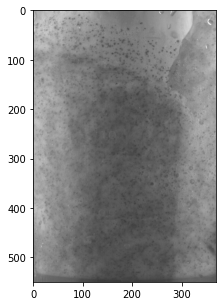

In [5]:
@pims.pipeline
def gray(image):
    return image[:, :, 0]  # Take just the green channel

@pims.pipeline
def crop(img):
    """
    Crop the image to select the region of interest
    """
    x_min = 400
    x_max = 770
    y_min = 300
    y_max = 850
    
    return img[y_min:y_max,x_min:x_max]

rawframes = crop(pims.open(IMAGES_PATH))
plt.imshow(rawframes[550]);


print(f"Frame time: {FRAME_TIME*1000:.2f} ms")

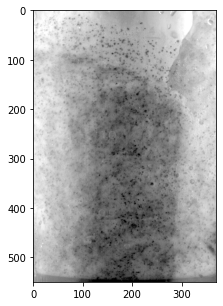

In [6]:
@pims.pipeline
def preprocess_foam(img):
    """
    Apply image processing functions to return a binary image
    """
    # Crop the pictures as for raw images.
    img = gray(crop(img))
    
    percentiles = np.percentile(img, (0.5, 99.5))
    # array([ 1., 28.])
    scaled = exposure.rescale_intensity(img, in_range=tuple(percentiles))
    image_bright = exposure.adjust_gamma(scaled, gamma=0.5,gain=1)
    
#     print(img.max(), img.min())
    
#     img_scaled = exposure.rescale_intensity(img)
#     print(img_scaled.max(), img_scaled.min())
    
    # Apply thresholds
#     adaptive_thresh = filters.threshold_local(img,35)
#     idx = img > adaptive_thresh
#     idx2 = img < adaptive_thresh
#     img[idx] = 0
#     img[idx2] = 255
#     img = ndimage.binary_dilation(img)
#     img = ndimage.binary_dilation(img)
    return util.img_as_int(image_bright)


frames = preprocess_foam(pims.open(os.path.join(IMAGES_PATH)))
plt.imshow(frames[550]);

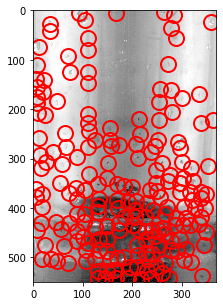

In [18]:
if not (is_variable_loaded("f_0")):
    f_0 = tp.locate(frames[frame_no], 11, invert=True, minmass=35000)
    save_table_backup(f_0,"f_0.pkl")
    tp.annotate(f_0, frames[frame_no]);
 
frame_no = 0
f_0 = tp.locate(frames[frame_no], 11, invert=True, minmass=35000)
plt.imshow(frames[frame_no])
tp.annotate(f_0, frames[frame_no]);

In [9]:
display(f_0.head(10))
f_0.shape

,y,x,mass,size,ecc,signal,raw_mass,ep
1,9.119602,104.987868,39901.845113,1.627814,0.098102,3880.784965,782797.0,-1.135672
2,9.473976,121.007236,38093.093267,2.611746,0.155108,1513.788110,997516.0,1.564495
3,9.430078,275.517942,36076.821284,1.814046,0.136161,3172.681903,860283.0,-3.011031
4,10.235116,10.363573,45620.529790,1.690967,0.179915,4148.501782,198385.0,-0.199329
7,10.741690,183.875956,62642.567001,1.579329,0.073385,6068.142250,1336513.0,0.329109
8,10.412928,46.441982,40205.363114,2.828626,0.226870,1468.482187,398331.0,-0.277649
9,12.904791,234.286171,92675.641532,1.909947,0.097111,6119.467841,1147093.0,0.588981
10,14.058673,287.907642,36832.131216,1.768239,0.075938,3149.870530,902043.0,-27.362178
12,14.511299,354.408261,100762.590362,2.643632,0.154808,4123.155811,588379.0,-0.443150
14,20.420453,166.965351,63237.880491,2.895986,0.154107,2356.541641,1238721.0,0.426191


(383, 8)

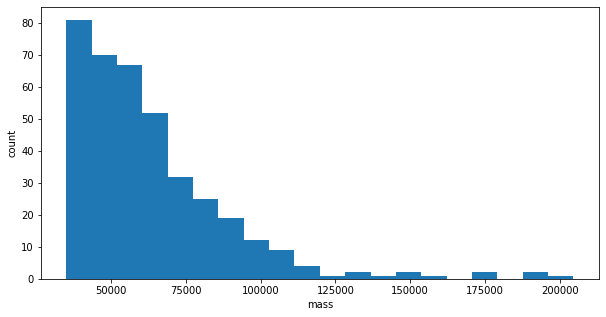

In [11]:
fig, ax = plt.subplots()
ax.hist(f_0['mass'], bins=20)

# Optionally, label the axes.
ax.set(xlabel='mass', ylabel='count');

array([[<AxesSubplot:title={'center':'x'}>,
        <AxesSubplot:title={'center':'y'}>]], dtype=object)

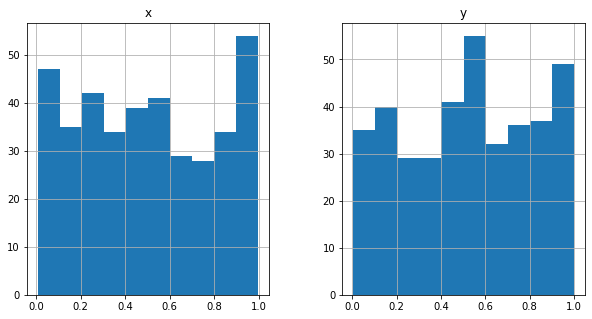

In [12]:
tp.subpx_bias(f_0)

In [13]:
if not(is_variable_loaded("f")):
    f = tp.batch(frames[::], 11, invert=True, minmass=20000);
    save_table_backup(f,'f.pkl')
    display(f.head())

Frame 4143: 458 features


,y,x,mass,size,ecc,signal,raw_mass,ep,frame
0,4.443496,263.825568,44813.448925,2.490385,0.249968,2520.855551,714943.0,0.473588,0
1,5.332119,167.762539,45286.287954,2.555904,0.330877,1986.443527,1062032.0,0.201546,0
2,5.965684,91.985588,130384.323187,2.788211,0.330512,5455.575154,667405.0,0.580995,0
3,8.644009,284.771886,91938.613061,2.939274,0.439537,3227.256277,734609.0,0.439942,0
4,14.412309,64.342185,26219.703593,2.468399,0.127769,1170.926102,156495.0,-0.404184,0


In [14]:
if not(is_variable_loaded("t")):
    t = tp.link(f, 5, memory=3)
    save_table_backup(t,"t.pkl")
    display(t.head())

Frame 4143: 458 trajectories present.


,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle
0,4.443496,263.825568,44813.448925,2.490385,0.249968,2520.855551,714943.0,0.473588,0,0
176,408.120646,130.688296,132084.465280,2.483575,0.214775,6115.211581,2067549.0,0.075652,0,1
177,408.817422,67.403960,27858.792294,3.086397,0.358407,1058.691783,792948.0,0.363362,0,2
178,411.453164,87.594551,76907.787757,3.006728,0.405632,2649.457375,1067812.0,0.199636,0,3
179,412.891136,105.109977,91275.339411,2.955874,0.449763,3150.614786,1469762.0,0.120341,0,4


In [15]:
if not(is_variable_loaded("t1")):
    t1 = tp.filter_stubs(t, 2)
    # Compare the number of particles in the unfiltered and filtered data.
    print('Before:', t['particle'].nunique())
    print('After:', t1['particle'].nunique())
    save_table_backup(t1, 't1.pkl')
    display(t1.head())

Before: 483800
After: 285992


,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle
frame,,,,,,,,,,
0,4.443496,263.825568,44813.448925,2.490385,0.249968,2520.855551,714943.0,0.473588,0,0
0,408.120646,130.688296,132084.465280,2.483575,0.214775,6115.211581,2067549.0,0.075652,0,1
0,408.817422,67.403960,27858.792294,3.086397,0.358407,1058.691783,792948.0,0.363362,0,2
0,411.453164,87.594551,76907.787757,3.006728,0.405632,2649.457375,1067812.0,0.199636,0,3
0,412.728715,266.366433,55713.427762,2.913771,0.313824,2213.769984,1933783.0,0.082508,0,5


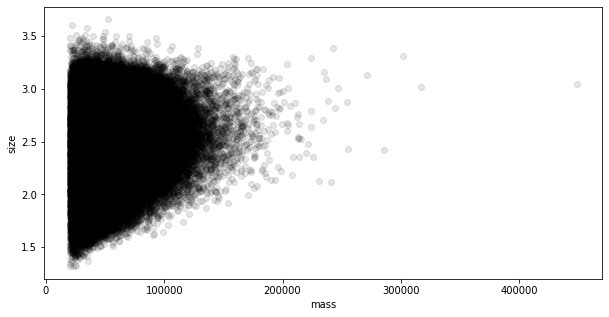

In [19]:
plt.figure()
tp.mass_size(t1.groupby('particle').mean()); # convenience function -- just plots size vs. mass

In [20]:
if not(is_variable_loaded("t2")):
    t2 = t1[((t1['mass'] < 80000) & (t1['size'] < 3.00))]
    save_table_backup(t2, "t2.pkl")
    display(t2.head())

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle
frame,,,,,,,,,,
0,4.443496,263.825568,44813.448925,2.490385,0.249968,2520.855551,714943.0,0.473588,0,0
0,412.728715,266.366433,55713.427762,2.913771,0.313824,2213.769984,1933783.0,0.082508,0,5
0,417.701643,338.950772,44668.999199,2.907628,0.368666,1642.206322,1059721.0,0.202320,0,6
0,419.905947,289.157298,53171.528276,2.689716,0.207768,2106.212095,1363364.0,0.134481,0,10
0,426.022503,32.571456,31668.264102,2.961041,0.327750,1393.835930,1014612.0,0.218710,0,12


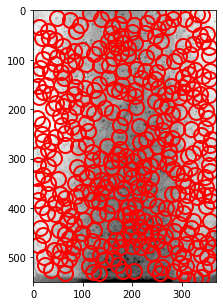

In [25]:
plt.figure()
frame_no=4000
tp.annotate(t2[t2['frame'] == frame_no], frames[frame_no]);

In [ ]:
# col_names = ['dx', 'dy', 'x', 'y', 'frame', 'particle']
# # Creating an empty dataframe to store results
# data = pd.DataFrame(np.zeros(shape=(1, 6), dtype=np.int64), columns=col_names)
# display(data)
    
# for item in set(t2.particle):      
#         sub = t2[t2.particle==item]
        
#         if sub.shape[0]<=2:
#             # Cases in which particle only has 1 or 2 rows of data
#             pass
#         else:    
#             ddx = pd.DataFrame(np.gradient(sub.x), columns=['dx',])
#             ddy = pd.DataFrame(np.gradient(sub.y), columns=['dy',])
        
#             new_df = pd.concat((dvx,dvy, sub.x.reset_index(drop=True), sub.y.reset_index(drop=True),
#                                 sub.frame.reset_index(drop=True), sub.particle.reset_index(drop=True)),
#                                 axis=1, names=col_names, sort=False)
#             data = pd.concat((data, new_df), axis=0)

# for item in set(data.particle):      
#         sub = data[data.particle==item]
            
            
            
# # dvx = pd.DataFrame(np.gradient(dx)/FRAME_TIME, columns=['vx',])
# # dvy = pd.DataFrame(np.gradient(dy)/FRAME_TIME, columns=['vy',])
    
# # This is to get rid of the first 'np.zeros' row and to reset indexes
# data = data.reset_index(drop=True)
# data = data.drop(0)
# data = data.reset_index(drop=True)


In [ ]:
if not(is_variable_loaded("v_data")):
    
    v_data = pd.DataFrame()
    for p in set(t2.particle):
        p_data = t2[t2.particle==p]
        dx = np.diff(p_data.x)
        dy = np.diff(p_data.y)
        dt = np.diff(p_data.frame)/FRAMES_PER_SECOND
        v = np.sqrt(dx**2+dy**2)/dt
        vx = dx/dt
        vy = dy/dt

        new_df = pd.concat((p_data.x.reset_index(drop=True), p_data.y.reset_index(drop=True), pd.Series(abs(dx)).rename("dx"), 
                            pd.Series(abs(dy)).rename("dy"), pd.Series(v).rename("v"), pd.Series(vx).rename("vx"),pd.Series(vy).rename("vy"),pd.Series(dt).rename("dt"), p_data.frame.reset_index(drop=True), 
                            p_data.particle.reset_index(drop=True)), axis=1, sort=False)
        v_data = pd.concat((v_data, new_df), axis=0)
    
    save_table_backup(v_data,'v_data.pkl')
    print(v_data['vx'].min(), v_data['vx'].max())
    print(v_data['vy'].min(),v_data['vy'].max())
    display(v_data.head(20))

In [ ]:
if not(is_variable_loaded("v_data_filtered")):
    v_data_filtered = v_data[(v_data['y'] > (0)) & ((np.absolute(v_data['v'])) > 400)]
    print(v_data_filtered['vx'].min(), v_data_filtered['vx'].max())
    print(v_data_filtered['vy'].min(),v_data_filtered['vy'].max(), v_data_filtered.shape)
    save_table_backup(v_data_filtered, 'v_data_filtered.pkl')
    display(v_data_filtered.head(20))

In [ ]:
def random_hex(length):
    return ''.join([random.choice('ABCDEF0123456789') for i in range(length)])

scale=2
start_frame = 100
num_frames = 10
start_opacity = 0.1*255
end_opacity = int(255*0.5)
current_opacity = start_opacity
opacity_step = (end_opacity - start_opacity) / (num_frames-1)

# plt.figure()
px = 1 / plt.rcParams['figure.dpi']
linewidth = 0.4* px / scale

for i in range(start_frame, start_frame + num_frames):
    
    opacity_hex = str(hex(int(current_opacity)))[2:]
    
    random_colour = "#"+"FFFF"+random_hex(2)+opacity_hex
    colour = "#FF0000"+opacity_hex
    
    current_opacity += opacity_step
    d = v_data_filtered[v_data_filtered.frame==i]
    
    plt.imshow(frames[i+2000])
    plt.quiver(d.x, d.y, d.vx, -d.vy, pivot='middle', headwidth=5, headlength=6, color=random_colour, width=linewidth)

    plt.axis('off')
   
fig = plt.gcf()
fig.set_size_inches(350*scale*px,524*scale*px)
plt.savefig(os.path.join(OUTPUTS_PATH,generate_filename("png")),bbox_inches='tight', pad_inches=0)


In [ ]:
key = 'vy'

v_data_filtered[key]

print(f"Average of column {key} is {np.average(v_data_filtered[key])}")
print(f"Median of column {key} is {np.median(v_data_filtered[key])}")

In [ ]:
# a2D = np.array([[1, 2], [3, 4]])
# print(a2D)
# print(f"array average 1: {np.average(a2D, axis=0)}")
# print(f"array average 2: {np.average(a2D, axis=1)}")



# d = {'sample_col1': [100, 2, 1,2],
#      'sample_col2': [4, 5, 6,5], 
#      'sample_col3': [7, 8, 9,12]} 

# df = pd.DataFrame(d)

# df['mean'] = df.mean(axis=1)

# display(df)

In [ ]:
# import math

# def sin(x, y):
#     return np.sin(x) + np.sin(y)

# def sum(x,y):
#     return x+y

# grid_height = frames[0].shape[0]
# grid_width = frames[0].shape[1]

# grid_spacing = 2 * math.floor(grid_width / 50)

# print(f"Grid spacing set to {grid_spacing} px\n")

# grid_x = np.arange(0, grid_width, grid_spacing)
# grid_y = np.arange(0, grid_height, grid_spacing)


# print(grid_x.shape)
# print(grid_y.shape)


# # grid_x = np.linspace(-10,10,50)
# # grid_y = np.linspace(-10,10,50)

# xx, yy = np.meshgrid(grid_x, grid_y)

# print(xx.shape)
# print(yy.shape)

# print(xx[1][5],yy[1][5])

# Z = sum(xx,yy)


# df = pd.DataFrame(Z)
# # display(df.head(50))

# fig = plt.figure(figsize=(9, 6))
# # Build the plot
# plt.scatter(xx,yy, s=0.5)
# plt.axis("equal")
# # plt.quiver(xx,yy,-yy,xx)
 
# # Display a color scale (values denoted by colors)
# plt.show()
